# 07. PyTorch Experiment Tracking

We've trained a few models now on the journey to making FoodVision.

And so far we've kept track of them via `Python Dictionaries` or just comparing them by the metric print outs during training.

**but, what if we want to run a dozen (or more) different models at once?**

There's a better way to keep track of the models.

It's called `Experiment Tracking`.

and experiment tracking is very important and integral to machine learning.

Since it is an important topic, you can consider this notebook your first milestone project.

So welcome to `Milestone Project 1: FoodVision Mini Experiment Tracking`

we are going to see `how we can track our machine learning experiments`

## What is experiment tracking?
If the number of experiments we run starts to increase, this naive way of tracking the results with print out and dictionaries could get out of hand.

So, if we're following the machine learning practitioner's motto of experiment, experiment, experiment, we'll want to track them all.

![](07_experiment_tracking.png)

Now, when we have this many models and tracking their results, we'll start to notice how quickly it can get out of hand.

## Different ways to track machine learning experiments.

There are many different ways to track machine learning experiments as there is experiments to run.

Few of them are.
| Method | Setup | Pros | Cons | Cost |
| ------ | ----- | ---- | ---- | ---- |
| PyThon dictionaries, csv files, printouts | None | Easy to setup, runs in pure python | Hard to keep track of large numbers of experiments | Free |
| **Tensorboard** | minimal, install `tensorboard` | Extensions built into PyTorch, widely recognized and used, easily scales. | User-experience not as nice as other options. | Free |
| **Weights and Biases Experiment Tracking** | Minimal, install `wandb`, make an account | Incredible user experience, make experiments public, tracks almost anything. | Requires external resource outside of PyTorch. | Free for personal use |
| MLFlow | Minimal, install `mlflow` and starting tracking | Fully open-source MLOps lifecycle management, many integrations. | Little bit harder to setup a remote tracking server than other services. | Free |

![](expriment_tracking_ways.png)

**Note:** There are more than these, which we can search online later.

## What we're going to cover

we're going to run several different modeling experiments with various levels of data, model size, and training time to try and improve on FoodVision.

We'll look at `TensorBoard` to track our experiments. Cause it is tighly integrated with PyTorch and it is widely used.

However, the principles we're going to cover are similar across all of the other tools for experiment tracking.

Here are the topics we're going to cover:
| Topic |
| :-----: |
| 0. Setting up |
| 1. Get Data |
| 2. Create **Datasets and DataLoaders** |
| 3. Get and customize a **pretrained model** |
| 4. **Train a model** and track the results |
| 5. View our model's results in **`TensorBoard`** |
| 6. Create a **helper function to track experiments** |
| 7. **Setting** up a series of **modeling experiments** |
| 8. **View modeling experiments** in TensorBoard |
| 9. **load in the best model** and **make predictions** with it |


## 0. Setting up

To save us writing some code, we're going to be leveraging some of the Python scripts (such as `data_setup.py` and `engine.py`) we created in section `05. PyTorch Going Modular`

Specifically, we're going to download the `going_modular` directory fromt he `pytorch-deep-learning` repository (if we don't already have it).

we'll also get the `torchinfo` package if it's not available.

`torchinfo` will help us letter to visualize the summaries of our model(s).

In [1]:
import torch
import torchvision
from torchvision import transforms


print(f'torch version: {torch.__version__}')
print(f'torchvision version: {torchvision.__version__}')

torch version: 2.2.2
torchvision version: 0.17.2


In [2]:
import matplotlib.pyplot as plt
from torchinfo import summary

try:
    from going_modular.going_modular import data_setup, engine
except:
    print("[INFO] Couldn't find going modular scripts, downloading them from the GitHub")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular ./
    !rm -=rf pytorch-deep-learning
    from going_modular import data_setup, engine
    

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### create a helper function to set seeds

since we've been setting random seeds a whole bunch throughout previous sections, how about we functionize it?

let's create a function to 'set the seeds' called `set_seeds()`

In [4]:
# set seeds

def set_seeds(seed: int = 42):
    """
    Args:
        seed: (int, optional): Random seed to set. Defaults to 42
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    

## 1. Get data

As always, before we can run machine learning experiments, we'll need a dataset.

we're goig to continue trying to imporove upon the results we've been getting on FoodVision.

In the previous section, 06. PyTorch Transfer Learning, we saw how powerful using a pretrained model and transfer learning could be when classifying images of pizza, steak, and sushi.

**So, how about we run some experiments and try to further improve our results?**

To do so, we'll use similar code to the previous section to download the pizza_steak_sushi.zip. **Except this time, its functionized.**

This will allow us to use it again later.

In [5]:
import os
from zipfile import ZipFile
import requests

from pathlib import Path

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True):
    data_path = Path('data')
    image_path = data_path / destination

    # create the path if not existed
    if image_path.is_dir():
        print(f'[INFO] {image_path} directory already exists. Skipping download.')
    else:
        print(f"[INFO] {image_path} doesn't exists. Creating one.")
        image_path.mkdir(parents=True, exist_ok=True)

        target_file = Path(source).name
        with open(data_path / target_file, 'wb') as f:
            request = requests.get(source)
            print('[INFO] Downloading...')
            f.write(request.content)
            print('Downloaded')
        with ZipFile(data_path / target_file, 'r') as zip_file:
            print(f'[INFO] Unzipping {target_file} data...')
            zip_file.extractall(image_path)
            print(f'[INFO] Extracted.')

        # remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    return image_path
    
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory already exists. Skipping download.


PosixPath('data/pizza_steak_sushi')

## 2. Create Datasets and DataLoaders

Now we've got some data, let's turn it into PyTorch DataLoaders.

We can do so using the `create_dataloaders()` function from 05. PyTorch Going Modular.

**Since we'll be using transfer learning and specifically pretrained models from `torchvision.models`, we'll create a transform to prepare our images correctly.**

To Transform our images into tensors, we can use:
1 Manually created transforms using `torchvision.transforms`
2. Automatically create transforms using
`torchvision.models.MODEL_NAME. MODEL_WEIGHTS.DEFAULT.transforms()`
    - where `MODEL_NAME` is a specific torchvision.models architecture, `MODEL_WEIGHTS` is a specific set of pretrained weights and `DEFAULT` means the "best available weights".

We will see the manual transformation here. And for that, we need to be sure that the images are normalized in `ImageNet` format (because `torchvision.models` are all pretrained in ImageNet)

We can do this with:
```
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
```

### 2.1. Create DataLoaders using Manually created transforms

In [6]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

# setup ImageNet normalization levels
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
# create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    normalize
])
print(f'Manually create transforms: {manual_transforms}')

# # create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32)
train_dataloader, test_dataloader, class_names

Manually create transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x112d7a380>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Create DataLoaders using automatically created transforms 
Let's create the same transforms using automatic transforms

In [7]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

# load weights from the pretrained model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
automatic_transforms = weights.transforms()
print(f'Automatically created transforms: {automatic_transforms}')

# create train and test dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms,
    batch_size=32)
train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x1273c1f60>,
 ['pizza', 'steak', 'sushi'])

## 3. Gettina a pretrained model, freezing the base layers and chaning the classifier head

In [8]:

# load pretrained model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)

# freeze the parameters
for param in model.features.parameters():
    param.requires_grad = False

# change the classifier head
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=3, bias=True)
).to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [9]:
# view the model info
from torchinfo import summary

summary(model=model,
        input_size=(32,3,224,224), # same size as input of the model we imported
        verbose=False,
        col_width=20,
        col_names=['input_size','output_size', 'num_params', 'trainable'],
        row_settings=['var_names']
       )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train model and track the results

In [10]:
# lets setup loss function and an optimiser
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

### 4.1 Adjust `train()` function to track results with `SummaryWriter()`

Let's add the final piece to track our experiments.

Previously, we've tracked our modelling experiments using multiple Python dictionaries (one for each model)

But we can image that this could get out of hand if we were running anything more than a few experiments.

**`Not to worry, we have better options`**

We can use PyTorch's `torch.utils.tensorboard.SummaryWriter()` class to save various parts of our model's training progress to file.

By default, the `SummaryWriter()` class saves various information about our model to a file set by the `log_dir` parameters.

The default location for `log_dir` is under `runs/CURRENT_DATETIME_HOSTNAME`, where the `HOSTNAME` is the name of our computer

**The outputs of the `SummaryWriter()` are saved in [TensorBoard](https://www.tensorflow.org/tensorboard) format**

Tensorboard is a part of the TensorFlow deep learning library and is an excellent way to visualize different parts of our model.

In [11]:
# create a SummaryWriter() instance

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

Now to use the writer, we have to create a training loop or use it in existing `train()` function.

lets use the `train()` function from `engine.py` and adjust it to use `writer`

Specifically, we'll add the ability for our `train()` function to log our model's training and test loss and accuracy values.

We can do this with `writer.add_scalars(main,_tag, tag_scalar_dict), where:
- `main_tag` (string) - the name for the scalers being tracked(eg. `accuracy`
- `tag_scalar_dict` (dict) - a dictionary of the values being tracked (eg. `{'train_loss': 0.3454}`

One we've finished tracking values, we'll call `writer.close()` to tell the `writer` to stop looking for values to track.

In [12]:
from typing import List, Dict
from tqdm.auto import tqdm

from going_modular.going_modular.engine import train_step, test_step

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int = 5,
          device = torch.device) -> Dict[str, List]:
    # create an empty results dictionary
    results = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                           dataloader=test_dataloader,
                                           loss_fn=loss_fn,
                                           device=device)
        # print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # update results dictionary
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

        ## New: Experiment tracking ##
        # add loss results to SummaryWriter()
        writer.add_scalars(main_tag="Loss",
                          tag_scalar_dict={"train_loss": train_loss,
                                           "test_loss": test_loss
                                          },
                           global_step=epoch
                         )
        # add accuracy results to SummaryWriter
        writer.add_scalars(main_tag='Accuracy',
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc
                                           },
                           global_step=epoch
                          )
        # Track the PyTorch model architecture
        writer.add_graph(model=model,
                        # pass the example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device)
                        )
    # close the writer
    writer.close()

    # Return the filled results at the end of the epochs
    return results

Now lets try to train themodel with 5 epochs

In [13]:
# train the model
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0871 | train_acc: 0.3984 | test_loss: 0.9147 | test_acc: 0.6108
Epoch: 2 | train_loss: 0.8945 | train_acc: 0.6836 | test_loss: 0.8354 | test_acc: 0.6411
Epoch: 3 | train_loss: 0.7468 | train_acc: 0.9062 | test_loss: 0.6767 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.6701 | train_acc: 0.7812 | test_loss: 0.6351 | test_acc: 0.9062
Epoch: 5 | train_loss: 0.6285 | train_acc: 0.8203 | test_loss: 0.6249 | test_acc: 0.8759


In [14]:
results

{'train_loss': [1.087058961391449,
  0.8945116028189659,
  0.7468452602624893,
  0.6701110824942589,
  0.6285387836396694],
 'train_acc': [0.3984375, 0.68359375, 0.90625, 0.78125, 0.8203125],
 'test_loss': [0.9146990776062012,
  0.835378368695577,
  0.6767362753550211,
  0.6351432800292969,
  0.6248999834060669],
 'test_acc': [0.6107954545454546,
  0.6410984848484849,
  0.9166666666666666,
  0.90625,
  0.8759469696969697]}

## View our model's results in TensorBoard

The SummaryWriter() class stores our model's results in a directory called `runs/` in TensorBoard format by default.

TensorBoard is a visualization program create by the TensorFlow team to view and inspect information about model and the data.

Now, let's visualize, visualize, and visualize.

You can view TensorBoard in a number of ways:
| **Code Environment** | **How to view TensorBoard** | **Resource** |
| :--: | :--: | :--: |
| VS Code (notebooks or Python scripts | Press `Shift + CMD + P -> search "Python:launch TensorBoard". | -- |
|**Jupyter and Colab Notebooks**| load it with %load_ext tensorboard and then view your results with `%tensorboard -- logdir DIR_WITH_LOGS`| `torch.utils.tensorboard` |


In [18]:
%load_ext tensorboard
%tensorboard --logdir runs --bind_all

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## 6. Create a helper function to build `SummaryWriter()` instances

`SummaryWriter` class logs various information to a directory specified by `log_dir` parameter. `SummaryWriter(log_dir=...)`

**Let's create a helper function to create a custom directory per experiment**

We'd like to track things like:
- Experiement date/timestamp
- Experiment Name
- Model Name
- Extra
  
We can track almost anything here and be as creative as we want but these should be enough to start.

Lets do:
1. Create a helper function called `create_writer()` that produces an instance of `SummaryWriter()` with a custom `log_dir`
2. the `log_dir` will look like `runs/YY-MM-DD/experiment_name/model_name/extra`
3. Where `YYYY-MM-DD` is the date the experiment was run.


In [23]:
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str = None) -> torch.utils.tensorboard.SummaryWriter:
    from datetime import datetime
    import os

    # get timestamp of current date
    timestamp = datetime.now().strftime('%Y-%m-%d')

    log_dir = log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    
    if extra:
        log_dir = os.path.join(log_dir, extra)
    print(f'[INFO] Created SummaryWriter, saving to: {log_dir}')
    
    return SummaryWriter(log_dir=log_dir)

Let's try it out.

In [24]:
# Create an example writer
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")

[INFO] Created SummaryWriter, saving to: runs/2024-08-19/data_10_percent/effnetb0/5_epochs


### 6.1 Update the `train()` function to include a `writer` paramter

In [68]:
from typing import List, Dict
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.SummaryWriter
         ) -> Dict[str,List]:
    
    results = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           device=device)
          # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # update the results dictionary
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

        ### Use the writer parameter to track the experiments ###
        if writer:
            writer.add_scalars(main_tag='Loss',
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss
                                               },
                               global_step=epoch
                              )
            writer.add_scalars(main_tag='Accuracy',
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc
                                               },
                               global_step=epoch
                              )
            writer.close()
            
    # Return the filled results at the end of the epochs
    return results

## 7. Setting up for multiple model/experiments

What if we could `run multiple experiments` and `inspect the results all together`?

Let's do that. 🔥🔥🔥🔥🔥

### 7.1. What kind of experiments should we run?

There's no limit to the experiments we can run.

We have to figure that out by doing `experiment, experiment, experiment!`

Every hyperparameter stands as a starting point for a different experiment:
- Change the number of **epochs**
- Change the number of **layers/hidden units**
- Change the amount of **data**
- Change the **learning rate**
- Try different kinds of **data augmentation**
- Choose different **model architecture**

***With practice and running many different experiments, we'll start to build an intuition of what might help our model***

Generally, **`Bigger the model and bigger the data -> better the performance.`**

However, if we're approaching the model for the first time, ***`We should start small` and if something works then `scale it up`***

<h3>💡💡💡
Our first batch of experiments should take no longer than few second to few minutes.💡💡💡
</h3>
Because, the quicker we can experiment, the faster we can work out what works and what doesn't. 🔥🔥🔥



### 7.2. Experiments we're going to run.

Our goal is to improve the model without it getting too big.

In essense, our ideal model achieves a high level of test set accuracy(90%+) but doesn't take too long to train/perform inference(make prediction)

We've got plenty of options but how about we keep things simple?

Let's try a combination of:
1. A different amoiunt of data (10% vs 20% data)
2. A different model(`efficientnet_b0`, `efficientnet_b2`)
3. A different training time(5 epochs vs 10 epochs)

Let's break it down

| Experiment Number | Training Dataset | Model | No. of Epochs |
| :---: | :---: | :---: | :---: |
| 1 | 10% | EfficientNet_B0 | 5|
| 2 | 10% | EfficientNet_B2 | 5|
| 3 | 10% | EfficientNet_B0 | 10|
| 4 | 10% | EfficientNet_B2 | 10|
| 5 | 20% | EfficientNet_B0 | 5|
| 6 | 20% | EfficientNet_B2 | 5|
| 7 | 20% | EfficientNet_B0 | 10|
| 8 | 20% | EfficientNet_B2 | 10|


With each experiment, we slowly increase the amount of data, the model size and the length of training.

By the end, `experiment 8` will be using `double the data`, `double the model` and `double the length of training` compared to `experiment 1`.
🔥🔥

### 7.3 Download different datasets
<h3 class='h1'> Lets Download the data ⬇️ </h3>

Before we start running our series of experiments, we need to make sure our datasets are ready. 

lets download 10% of the data and 20% of the data for Food101 - pizza, steak, and sushi

***For consistency, all experiments will use the same testing dataset.***

In [29]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory already exists. Skipping download.
[INFO] data/pizza_steak_sushi_20_percent doesn't exists. Creating one.
[INFO] Downloading...
Downloaded
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...
[INFO] Extracted.


In [31]:
# setup the file path for the data

train_dir_10_percent = data_10_percent_path / 'train'
train_dir_20_percent = data_20_percent_path / 'train'

# setup the testing directory path
# note: we should use the same test dataset for the both models to compare the results

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


### 7.4 Transform Datasets and create DataLoader

To transform the data we can either use `manual_transform` or `automatic_transform`

we'll use manual transform here. And use the same transform across all the datasets.

The transform will
1. Resize the image
2. turn them to tensors with values between 0 and 1
3. Normalize them in a way so that their distributions are inline with ImageNet dataset.


In [41]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]
                                )

# transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    normalize
])

display(f'{normalize}', simple_transform)

'Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])'

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [44]:
# create dataloaders
BATCH_SIZE = 32
train_dataloader_10, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                 test_dir=test_dir,
                                                                 transform=simple_transform,
                                                                 batch_size=BATCH_SIZE)
train_dataloader_20, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                 test_dir=test_dir,
                                                                 transform=simple_transform,
                                                                 batch_size=BATCH_SIZE)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


### 7.5 Lets load the model
we load the model from `torchvision.models.<model_name>` and freeze the feature extractors and update the output classes.

In [52]:
import torchvision
from torchinfo import summary

weights_b0 = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights_b2 = torchvision.models.EfficientNet_B2_Weights.DEFAULT

effnetb0 = torchvision.models.efficientnet_b0(weights=weights_b0)
effnetb2 = torchvision.models.efficientnet_b2(weights=weights_b2)

summary(model=effnetb2,
        input_size=(32,3,224,224),
        col_width=20,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names']
       )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [55]:
print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")


Number of in_features to final layer of EfficientNetB2: 1408


Now that we know the required number of `in_features` for the EffNetB2 model, let's create a couple of helper function to setup our EffNetB0 and EffNetB2 models.

We want to do:
1. Get the base models from `torchvision.models`
2. Freeze the base layers in the model (set `requires_grad=False`)
3. Set the random seeds
4. Change the classifier head to suit our problem
5. Give the model name

In [58]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)

# create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False
    
    # 3. set seed\
    set_seeds()

    # 4. Change the classifier head
    model.classifier = torch.nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give model a name
    model.name = 'effnetb0'
    print(f'[INFO] Created new {model.name} model')

    return model

# create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False
    
    # 3. set seed\
    set_seeds()

    # 4. Change the classifier head
    model.classifier = torch.nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give model a name
    model.name = 'effnetb2'
    print(f'[INFO] Created new {model.name} model')

    return model

Let's try them out by creating an instance of EffNetB0 and EffNetB2, and check their `summary()`

In [59]:
effnetb0 = create_effnetb0()
# Get an output summary of the layers in our EffNetB0 feature extractor model (uncomment to view full output)
summary(model=effnetb0, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

[INFO] Created new effnetb0 model


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [60]:
effnetb2 = create_effnetb2()
# Get an output summary of the layers in our EffNetB0 feature extractor model (uncomment to view full output)
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

[INFO] Created new effnetb2 model


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

Looking at the outputs of the summaries, it seems the EffNetB2 backbone has nearly double the amount of parameters as EffNetB0.

| Model | Total Parameters (before) | Total Parameters (After) | Total Trainable |
|:-:|:-:|:-:|:-:|
|EfficientNetB0| 5,288,548| 4,011,391 |3,843 |
|EfficientNetB2| 9,109,994| 7,705,221 |4,227 |

This gives the backbone of the EffNetB2 model more opportunities to form a representation of our pizza, steak, and sushi data.

However, the trainable parameters of each model aren't very different. 🤔

<span class='alert-danger'>we'll see if these extra parameter head will lead to the better results.</span>

### 7.6 Create Experiments and set up training code

We've prepared our data and prepared our models, its **Set some experiments**

We'll start by creating two lists and a dictionary.
1. A `list` of the number of `epochs` we'd like to test (`[5,10]`)
2. A `list` of the `models` we'd like to test (`['effnetb0','effnetb2']`)
3. A `dictionary` of the different training `DataLoaders`

In [61]:
# 1. Create epochs list
num_epochs = [5,10]

# 2. Create models list (need to create a new model for each experiment)
models = ['effnetb0', 'effnetb2']

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {
    'data_10_percent':train_dataloader_10,
    'data_20_percent':train_dataloader_20,
}

Lists and dictionary created.

Now we can write the code to `iterate` through each of the different options and try out each of the different combinations.

We'll also `save the model` at the end of each experiment so `later` on we can `load back` in the best model and `use it for making predictions`.

Specifically, let's go through the following steps:
1. Set the random seeds (so that our experiment results are reproducible)
2. Keep track of different experiment numbers.
3. Loop through the `train_dataloaders` dictionary items for each of the different training DataLoaders.
4. Loop through the list of epoch numbers
5. Loop through the list of different model names.
6. Create information print outs for the current running experiments (so we know whats happening)
7. Check which model is the target model and create a new EffNetB0 or EffnetB2 (we create new instance of the model in each experiment so all models start from the same standpoint)
8. Create a new `loss function - torch.nn.CrossEntropyLoss()` and an `optimizer - torch.optim.Adam(params=model.parameters(), lr=0.001)` for each new experiment
9. Train the model with `the modified train() function` passing the appropriate details to the writer parameter
10. Save the trained model with an appropriate file name to file with `save_model()` from `utils.py` 

In [63]:
%%time
from going_modular.going_modular.utils import save_model

# 1. set random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs:

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == 'effnetb0':
                model = create_effnetb0() # creates a new model each time
            else:
                model = create_effnetb2()

            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(),
                                        lr=0.001
                                        )
            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  loss_fn=loss_fn,
                  optimizer=optimizer,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f'{epochs}_epochs')
                 )
            # 10. Save the model to file so we can get back the best model
            save_filepath = f'07_{model_name}_{dataloader_name}_{epochs} epoch.pth'
            save_model(model=model,
                       target_dir='models',
                       model_name=save_filepath)
            print("-"*50+'\n')
            

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model
[INFO] Created SummaryWriter, saving to: runs/2024-08-19/data_10_percent/effnetb0/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0551 | train_acc: 0.4727 | test_loss: 0.8891 | test_acc: 0.6328
Epoch: 2 | train_loss: 0.9245 | train_acc: 0.5820 | test_loss: 0.7750 | test_acc: 0.7070
Epoch: 3 | train_loss: 0.7603 | train_acc: 0.8555 | test_loss: 0.6033 | test_acc: 0.9141
Epoch: 4 | train_loss: 0.7635 | train_acc: 0.6992 | test_loss: 0.5765 | test_acc: 0.9297
Epoch: 5 | train_loss: 0.6399 | train_acc: 0.8750 | test_loss: 0.4665 | test_acc: 0.9102
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5 epoch.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model
[INFO] Created SummaryWriter, saving to: runs/2024-08-19/data_10_percent/effnetb2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0804 | train_acc: 0.3750 | test_loss: 0.8912 | test_acc: 0.8281
Epoch: 2 | train_loss: 0.8842 | train_acc: 0.6914 | test_loss: 0.7580 | test_acc: 0.8984
Epoch: 3 | train_loss: 0.8426 | train_acc: 0.6992 | test_loss: 0.6960 | test_acc: 0.9062
Epoch: 4 | train_loss: 0.7117 | train_acc: 0.7852 | test_loss: 0.5696 | test_acc: 0.9570
Epoch: 5 | train_loss: 0.6291 | train_acc: 0.9219 | test_loss: 0.5024 | test_acc: 0.9492
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5 epoch.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model
[INFO] Created SummaryWriter, saving to: runs/2024-08-19/data_10_percent/effnetb0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0551 | train_acc: 0.4727 | test_loss: 0.8891 | test_acc: 0.6328
Epoch: 2 | train_loss: 0.9245 | train_acc: 0.5820 | test_loss: 0.7750 | test_acc: 0.7070
Epoch: 3 | train_loss: 0.7603 | train_acc: 0.8555 | test_loss: 0.6033 | test_acc: 0.9141
Epoch: 4 | train_loss: 0.7635 | train_acc: 0.6992 | test_loss: 0.5765 | test_acc: 0.9297
Epoch: 5 | train_loss: 0.6399 | train_acc: 0.8750 | test_loss: 0.4665 | test_acc: 0.9102
Epoch: 6 | train_loss: 0.6528 | train_acc: 0.7578 | test_loss: 0.4466 | test_acc: 0.8906
Epoch: 7 | train_loss: 0.5614 | train_acc: 0.7695 | test_loss: 0.3982 | test_acc: 0.9492
Epoch: 8 | train_loss: 0.5326 | train_acc: 0.8125 | test_loss: 0.3890 | test_acc: 0.9570
Epoch: 9 | train_loss: 0.5281 | train_acc: 0.7773 | test_loss: 0.3619 | test_acc: 0.9648
Epoch: 10 | train_loss: 0.5284 | train_acc: 0.8125 | test_loss: 0.3966 | test_acc: 0.9688
[INFO] Saving model to: models/07_effnetb0_data_10_percent_10 epoch.pth
-------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0804 | train_acc: 0.3750 | test_loss: 0.8912 | test_acc: 0.8281
Epoch: 2 | train_loss: 0.8842 | train_acc: 0.6914 | test_loss: 0.7580 | test_acc: 0.8984
Epoch: 3 | train_loss: 0.8426 | train_acc: 0.6992 | test_loss: 0.6960 | test_acc: 0.9062
Epoch: 4 | train_loss: 0.7117 | train_acc: 0.7852 | test_loss: 0.5696 | test_acc: 0.9570
Epoch: 5 | train_loss: 0.6291 | train_acc: 0.9219 | test_loss: 0.5024 | test_acc: 0.9492
Epoch: 6 | train_loss: 0.5441 | train_acc: 0.9297 | test_loss: 0.4842 | test_acc: 0.9375
Epoch: 7 | train_loss: 0.6351 | train_acc: 0.7539 | test_loss: 0.4309 | test_acc: 0.9570
Epoch: 8 | train_loss: 0.5442 | train_acc: 0.8164 | test_loss: 0.4053 | test_acc: 0.9648
Epoch: 9 | train_loss: 0.5695 | train_acc: 0.8008 | test_loss: 0.3896 | test_acc: 0.9727
Epoch: 10 | train_loss: 0.4664 | train_acc: 0.8398 | test_loss: 0.3271 | test_acc: 0.9805
[INFO] Saving model to: models/07_effnetb2_data_10_percent_10 epoch.pth
-------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9653 | train_acc: 0.5646 | test_loss: 0.6867 | test_acc: 0.8688
Epoch: 2 | train_loss: 0.7036 | train_acc: 0.8042 | test_loss: 0.5137 | test_acc: 0.9146
Epoch: 3 | train_loss: 0.5831 | train_acc: 0.8292 | test_loss: 0.4379 | test_acc: 0.9104
Epoch: 4 | train_loss: 0.4550 | train_acc: 0.8938 | test_loss: 0.3813 | test_acc: 0.9333
Epoch: 5 | train_loss: 0.4353 | train_acc: 0.8667 | test_loss: 0.3452 | test_acc: 0.9396
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5 epoch.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model
[INFO] Created SummaryWriter, saving to: runs/2024-08-20/data_20_percent/effnetb2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9823 | train_acc: 0.5146 | test_loss: 0.7381 | test_acc: 0.8896
Epoch: 2 | train_loss: 0.7071 | train_acc: 0.8375 | test_loss: 0.5702 | test_acc: 0.9292
Epoch: 3 | train_loss: 0.5899 | train_acc: 0.8604 | test_loss: 0.4795 | test_acc: 0.9417
Epoch: 4 | train_loss: 0.5181 | train_acc: 0.8708 | test_loss: 0.4486 | test_acc: 0.9146
Epoch: 5 | train_loss: 0.5034 | train_acc: 0.8438 | test_loss: 0.3676 | test_acc: 0.9604
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5 epoch.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model
[INFO] Created SummaryWriter, saving to: runs/2024-08-20/data_20_percent/effnetb0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9653 | train_acc: 0.5646 | test_loss: 0.6867 | test_acc: 0.8688
Epoch: 2 | train_loss: 0.7036 | train_acc: 0.8042 | test_loss: 0.5137 | test_acc: 0.9146
Epoch: 3 | train_loss: 0.5831 | train_acc: 0.8292 | test_loss: 0.4379 | test_acc: 0.9104
Epoch: 4 | train_loss: 0.4550 | train_acc: 0.8938 | test_loss: 0.3813 | test_acc: 0.9333
Epoch: 5 | train_loss: 0.4353 | train_acc: 0.8667 | test_loss: 0.3452 | test_acc: 0.9396
Epoch: 6 | train_loss: 0.4322 | train_acc: 0.8604 | test_loss: 0.2845 | test_acc: 0.9437
Epoch: 7 | train_loss: 0.3496 | train_acc: 0.8729 | test_loss: 0.2701 | test_acc: 0.9479
Epoch: 8 | train_loss: 0.3780 | train_acc: 0.8896 | test_loss: 0.2701 | test_acc: 0.9521
Epoch: 9 | train_loss: 0.3838 | train_acc: 0.8604 | test_loss: 0.3181 | test_acc: 0.9229
Epoch: 10 | train_loss: 0.3706 | train_acc: 0.8562 | test_loss: 0.2276 | test_acc: 0.9583
[INFO] Saving model to: models/07_effnetb0_data_20_percent_10 epoch.pth
-------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9823 | train_acc: 0.5146 | test_loss: 0.7381 | test_acc: 0.8896
Epoch: 2 | train_loss: 0.7071 | train_acc: 0.8375 | test_loss: 0.5702 | test_acc: 0.9292
Epoch: 3 | train_loss: 0.5899 | train_acc: 0.8604 | test_loss: 0.4795 | test_acc: 0.9417
Epoch: 4 | train_loss: 0.5181 | train_acc: 0.8708 | test_loss: 0.4486 | test_acc: 0.9146
Epoch: 5 | train_loss: 0.5034 | train_acc: 0.8438 | test_loss: 0.3676 | test_acc: 0.9604
Epoch: 6 | train_loss: 0.4313 | train_acc: 0.8646 | test_loss: 0.3148 | test_acc: 0.9625
Epoch: 7 | train_loss: 0.3800 | train_acc: 0.9208 | test_loss: 0.2950 | test_acc: 0.9625
Epoch: 8 | train_loss: 0.3343 | train_acc: 0.9375 | test_loss: 0.2779 | test_acc: 0.9750
Epoch: 9 | train_loss: 0.3861 | train_acc: 0.8583 | test_loss: 0.2464 | test_acc: 0.9729
Epoch: 10 | train_loss: 0.3690 | train_acc: 0.8812 | test_loss: 0.2342 | test_acc: 0.9854
[INFO] Saving model to: models/07_effnetb2_data_20_percent_10 epoch.pth
-------------------------------------

## 8. View Experiments in TensorBoard

In [67]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
%load_ext tensorboard
%tensorboard --logdir runs --bind_all 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1444), started 12:21:11 ago. (Use '!kill 1444' to kill it.)

## 9. Load in the best model and make predictions with it

In [71]:
# Setup the best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10 epoch.pth"

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model


<All keys matched successfully>

In [72]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


In [73]:
Path(best_model_path).stat()

os.stat_result(st_mode=33188, st_ino=6287306, st_dev=16777225, st_nlink=1, st_uid=501, st_gid=20, st_size=31282042, st_atime=1724135771, st_mtime=1724135079, st_ctime=1724135079)

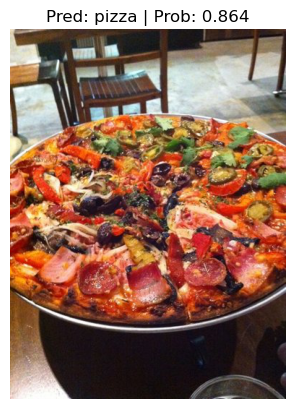

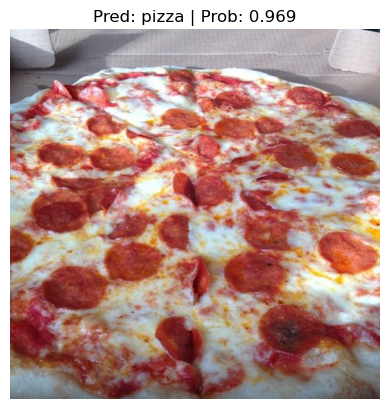

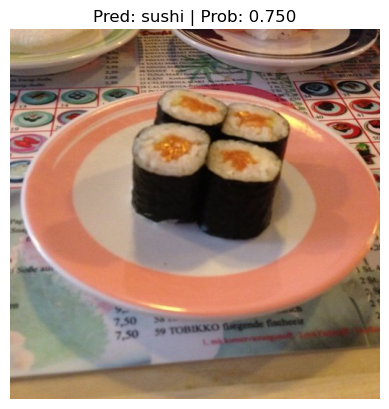

In [74]:
# Import function to make predictions on images and plot them 
# See the function previously created in section: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
from going_modular.going_modular.predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

### 9.1 Predict on a custo image with the best model

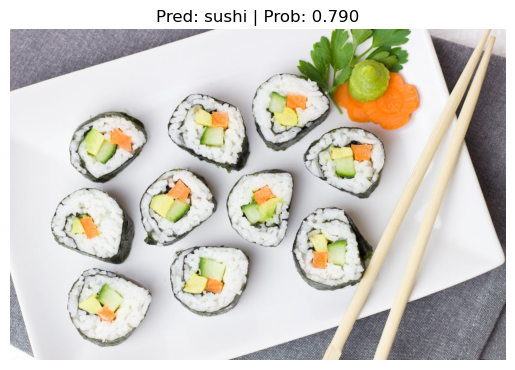

In [75]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/pexels_photo_357756.jpeg")


# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

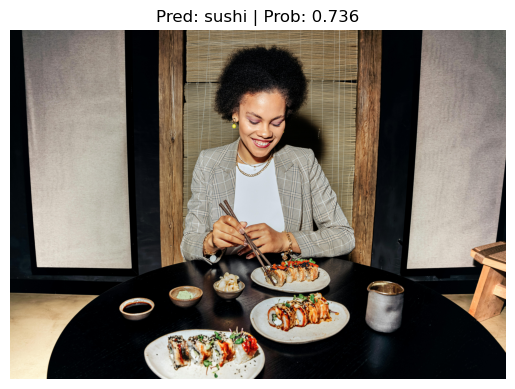

In [79]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/sushi_eating.jpg")


# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

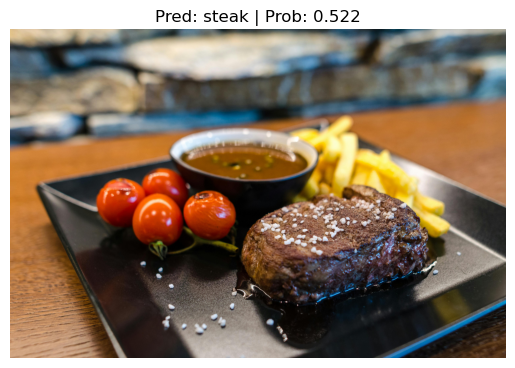

In [80]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/steak.jpg")


# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

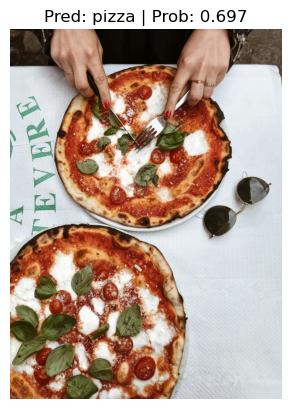

In [82]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/pizza.jpg")


# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

The main ideas you should take away from this Milestone Project 1 are:

- The machine learning practioner's motto: `experiment, experiment, experiment`! (though we've been doing plenty of this already).
- In the beginning, keep your experiments small so you can work fast, your first few experiments shouldn't take more than a few seconds to a few minutes to run.
- The more experiments you do, the quicker you can figure out what doesn't work.
- Scale up when you find something that works. For example, since we've found a pretty good performing model with EffNetB2 as a feature extractor, perhaps you'd now like to see what happens when you scale it up to the whole Food101 dataset from `torchvision.datasets`.
- Programmatically tracking your experiments takes a few steps to set up but it's worth it in the long run so you can figure out what works and what doesn't.
    - There are many different machine learning experiment trackers out there so explore a few and try them out.